In [1]:
using IonSim
using QuantumOptics
using QuantumOptics: timeevolution, stochastic
import DifferentialEquations
import PyPlot
const plt = PyPlot
using Distributions
using Expectations

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [3]:
C = Ca40(["S-1/2", "D-1/2"])
L = Laser()
νa = 1.5e6  # axial trap frequency
νr = 3e6    # radial trap frequency
chain = LinearChain(
        ions=[C], com_frequencies=(x=νr,y=νr,z=νa), 
        vibrational_modes=(x=[], y=[], z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;
mode = T.configuration.vibrational_modes.z[1]

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim C:\Users\suman\.julia\packages\IonSim\5Hvou\src\lasers.jl:84


VibrationalMode(ν=1.5e6, axis=ẑ, N=10)

# RAP on RSB transition

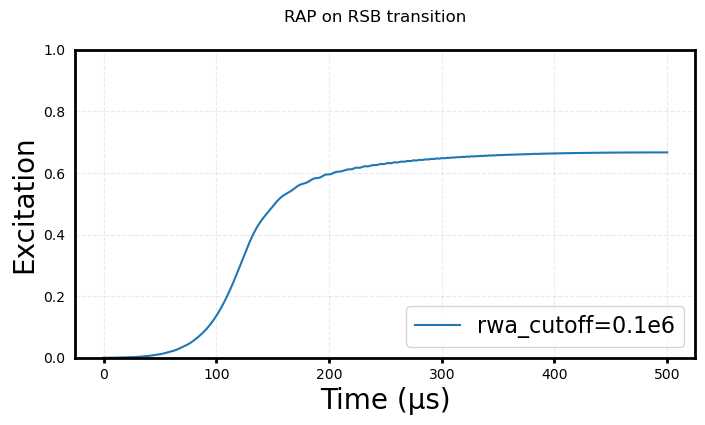

  0.605424 seconds (2.17 M allocations: 183.357 MiB, 8.65% gc time)


PyObject <matplotlib.legend.Legend object at 0x000000003DFD3790>

In [7]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

mode.N = 20
ψi_mode = thermalstate(mode, 2)

#ψi1 = dm(C["S-1/2"]) ⊗ dm(mode[2])
ψi1 = dm(C["S-1/2"]) ⊗ thermalstate(mode, 2)

δν = 300e3
Δϕ = 2π * (δν/2) * 1e-6
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
    else
        return 0
    end
end
L.E = Ω;
L.Δ  = Δf - mode.ν 

Tp = 500
tspan = 0:0.1:Tp
h = hamiltonian(T, rwa_cutoff=0.1e6)
@time tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi1, h)


ex1 = expect(ionprojector(T, "D-1/2"), ψt)
#plt.plot(tspan, ex1)
plt.plot(tout, ex1, label="rwa_cutoff=0.1e6")
#plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.suptitle("RAP on RSB transition")
plt.legend(loc="lower right", fontsize = 16)

# theoretical_nbar

In [5]:
n = one(C) ⊗ thermalstate(mode, 5)
ψi = dm(C["S-1/2"]) ⊗ dm(mode[5])
theoretical_nbar = expect(n, ψi)

0.06846786145937477 + 0.0im

## scaling with fock states |n>; sequence rsb RAP pulse followed by carrier pi pulse

In [6]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

mode.N = 20
ψi = dm(C["S-1/2"]) ⊗ dm(mode[5])
theoretical_nbar = expectation(n, ψi)
i = 0

while true
    # # simulation with RAP pulse on rsb transition
    δν = 300e3
    Δϕ = 2π * (δν/2) * 1e-6
    L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
    # amplitude Rabi_freq
    function Ω(t)
        if t < Tp
            return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
        else
            return 0
        end
    end
    L.E = Ω;
    L.Δ  = Δf - mode.ν 

    Tp = 500
    tspan = 0:0.1:Tp
    h = hamiltonian(T, rwa_cutoff=0.1e6)
    @time tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h)
    
    ψo = ψt[end]
    
    p = expect(ionprojector(T, "S-1/2"), ψo)
    if Bernoulli(p) == 1
        break
    
    # simulation with pi pulse on carrier
        L.Δ = Δf
        E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
        L.E = E1
        L.ϕ = 0

        tpi = 3 # length of pi pulse


        tlist = 0:0.1:tpi
        h = hamiltonian(T, rwa_cutoff=1e5)
        @time tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψo, h)

        ψi = ψo
        i += 1
    end
end
phonon_number_measurement = i
error = abs(theoretical_nbar - phonon_number_measurement) / theoretical_nbar

MethodError: MethodError: no method matching expectation(::Operator{CompositeBasis{Array{Int64,1},Tuple{Ca40,VibrationalMode}},CompositeBasis{Array{Int64,1},Tuple{Ca40,VibrationalMode}},SparseArrays.SparseMatrixCSC{Complex{Float64},Int64}}, ::Operator{CompositeBasis{Array{Int64,1},Tuple{Ca40,VibrationalMode}},CompositeBasis{Array{Int64,1},Tuple{Ca40,VibrationalMode}},Array{Complex{Float64},2}})
Closest candidates are:
  expectation(!Matched::Distribution{Univariate,Continuous}, ::Any) at C:\Users\suman\.julia\packages\Expectations\V3TEi\src\iterable.jl:251
  expectation(!Matched::Distribution{Univariate,Continuous}, ::Any, !Matched::Type{#s14} where #s14<:ExplicitQuadratureAlgorithm; kwargs...) at C:\Users\suman\.julia\packages\Expectations\V3TEi\src\iterable.jl:251

### sequence of simulation; pi pulse on carrier followed by bsb RAP pulse

  0.034385 seconds (6.93 k allocations: 581.875 KiB)


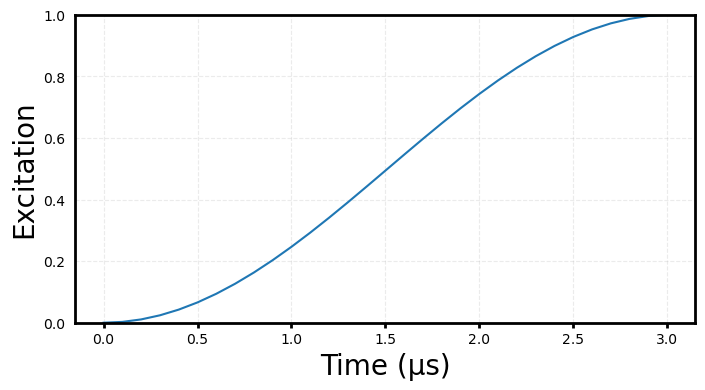

  4.144261 seconds (1.33 M allocations: 67.183 MiB, 84.07% gc time)


In [35]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L.Δ = Δf
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
L.E = E1
L.ϕ = 0

ψi1 = dm(C["S-1/2"]) ⊗ dm(mode[2])

tpi = 3 # length of pi pulse


tlist = 0:0.1:tpi
h = hamiltonian(T, rwa_cutoff=1e5)
@time tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψi1, h)

ψi2 = ψt[end]
δν = 300e3
Δϕ = 2π * (δν/2) * 1e-6
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
    else
        return 0
    end
end
L.E = Ω;
L.Δ  = Δf + mode.ν

Tp = 500
tspan = 0:0.1:Tp
h = hamiltonian(T, rwa_cutoff=1e5)
@time tout, ψt1 = timeevolution.schroedinger_dynamic(tspan, ψi2, h)

# ψi3 = ψt1[end]
# tlist = 0:0.1:tpi
# h = hamiltonian(T, rwa_cutoff=1e5)
# @time tout, ψt2 = timeevolution.schroedinger_dynamic(tlist, ψi3, h)

# ψi4 = ψt2[end]
# δν = 300e3
# Δϕ = 2π * (δν/2) * 1e-6
# L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
# # amplitude Rabi_freq
# function Ω(t)
#     if t < Tp
#         return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
#     else
#         return 0
#     end
# end
# L.E = Ω;
# L.Δ  = Δf + mode.ν

# Tp = 300
# tspan = 0:0.1:Tp
# h = hamiltonian(T, rwa_cutoff=1e5)
# @time tout, ψt3 = timeevolution.schroedinger_dynamic(tspan, ψi4, h)

ex1 = expect(ionprojector(T, "D-1/2"), ψt)
#plt.plot(tout, ex1)
plt.plot(tlist, ex1)
#plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

In [30]:
η = abs(get_η(mode, L, C))

0.07105425653011588